# Plots of Classifier Results
Folders `classification_results_rerun_all_517 `
Verified that this folder has all the experiments and the results are the same as using the data in folders `classification_results_additive_noise_515`, `classification_results_poisson_noise_516`, `classification_results_poisson_noise_psf_4_517`.

In [33]:
import numpy as np
from leyla_fns import *
import sys
sys.path.insert(0, '/home/lkabuli_waller/workspace/microscoBayes/')
from analysis.entropy import * 
from cleanplots import * 


### Loading Data
Fixed arrays for gaussian and poisson noise levels. These lists will load the data properly, then it'll be easily accessible for processing.

In [2]:
poisson_noise_levels = [2, 5, 10, 25, 50, 60, 80, 100]
gaussian_noise_levels = [25, 50, 75, 100, 125, 150, 200] # omitting 0 but 0 is also available

In [3]:
# modality ordering
modality_list = ['uc', 'psf_4', 'diffuser', 'phlat']
# cnn list ordering is unconvolved, psf_4, diffuser, phlat
poisson_cnn = [[], [], [], []]
gaussian_cnn = [[], [], [], []]
# simple network ordering is unconvolved, psf_4, diffuser, phlat
poisson_simple = [[], [], [], []]
gaussian_simple = [[], [], [], []]

for noise_level in poisson_noise_levels:
    for modality in modality_list:
        poisson_cnn[modality_list.index(modality)].append(np.load(f'./classification_results_rerun_all_517/test_accuracy_{noise_level}_noise_poisson_{modality}_psf_cnn_model.npy'))
        poisson_simple[modality_list.index(modality)].append(np.load(f'./classification_results_rerun_all_517/test_accuracy_{noise_level}_noise_poisson_{modality}_psf_simple_model.npy'))
for noise_level in gaussian_noise_levels:
    for modality in modality_list:       
        gaussian_cnn[modality_list.index(modality)].append(np.load(f'./classification_results_rerun_all_517/test_accuracy_{noise_level}_noise_gaussian_{modality}_psf_cnn_model.npy'))
        gaussian_simple[modality_list.index(modality)].append(np.load(f'./classification_results_rerun_all_517/test_accuracy_{noise_level}_noise_gaussian_{modality}_psf_simple_model.npy'))

### Accuracy vs. Noise Level plots with Photon axis.

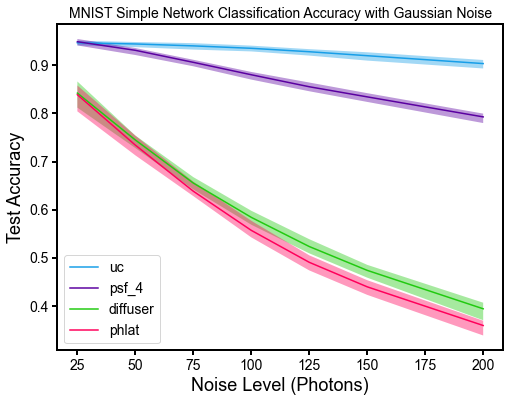

In [4]:
# simple network gaussian noise
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for modality in modality_list:
    error_lo, error_hi, mean = confidence_bars(gaussian_simple[modality_list.index(modality)], 7)
    ax.plot(gaussian_noise_levels, mean, '-', label=modality)
    ax.fill_between(gaussian_noise_levels, error_lo, error_hi, alpha=0.4)
plt.xlabel('Noise Level (Photons)')
plt.ylabel('Test Accuracy')
plt.title('MNIST Simple Network Classification Accuracy with Gaussian Noise')
plt.legend()

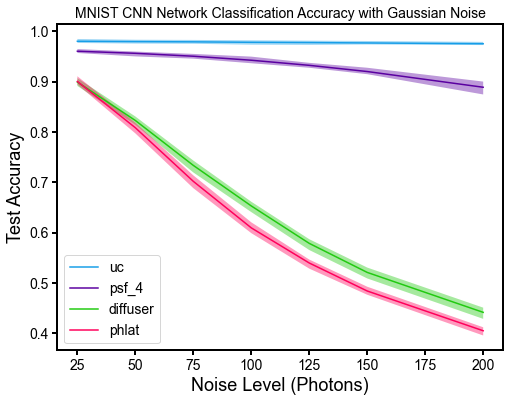

In [5]:
# cnn network gaussian noise
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for modality in modality_list:
    error_lo, error_hi, mean = confidence_bars(gaussian_cnn[modality_list.index(modality)], 7)
    ax.plot(gaussian_noise_levels, mean, '-', label=modality)
    ax.fill_between(gaussian_noise_levels, error_lo, error_hi, alpha=0.4)
plt.xlabel('Noise Level (Photons)')
plt.ylabel('Test Accuracy')
plt.title('MNIST CNN Network Classification Accuracy with Gaussian Noise')
plt.legend()

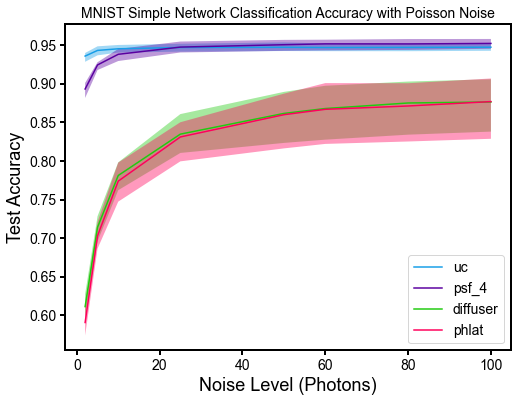

In [6]:
# simple network poisson noise
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for modality in modality_list:
    error_lo, error_hi, mean = confidence_bars(poisson_simple[modality_list.index(modality)], 8)
    ax.plot(poisson_noise_levels, mean, '-', label=modality)
    ax.fill_between(poisson_noise_levels, error_lo, error_hi, alpha=0.4)
plt.xlabel('Noise Level (Photons)')
plt.ylabel('Test Accuracy')
plt.title('MNIST Simple Network Classification Accuracy with Poisson Noise')
plt.legend()

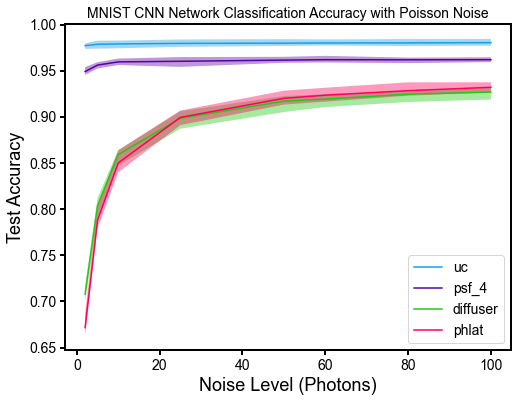

In [7]:
# cnn network poisson noise
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for modality in modality_list:
    error_lo, error_hi, mean = confidence_bars(poisson_cnn[modality_list.index(modality)], 8)
    ax.plot(poisson_noise_levels, mean, '-', label=modality)
    ax.fill_between(poisson_noise_levels, error_lo, error_hi, alpha=0.4)
plt.xlabel('Noise Level (Photons)')
plt.ylabel('Test Accuracy')
plt.title('MNIST CNN Network Classification Accuracy with Poisson Noise')
plt.legend()

### Calculating SNR from full datasets and making plots with SNR axis.
Need to make sure this isn't buggy? Log scale option probably isn't looking good yet.

#### Load PSFs.

In [11]:
diffuser_psf = load_diffuser_psf()
phlat_psf = load_phlat_psf()
psf_4_psf = load_4_psf()

#### Make full datasets to get mean photon values for noiseless signals.

In [12]:
#load mnist data
(x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()
data = np.concatenate((x_train, x_test), axis=0) # make one big glob of data
data = data.astype(np.float32)
for i in range(data.shape[0]):
    data[i] /= np.max(data[i])
    data[i] *= 1000 # convert to photons with arbitrary maximum value of 1000 photons
labels = np.concatenate((y_train, y_test), axis=0) # make one big glob of labels. 

# set seed value for reproducibility and tile data using full mnist dataset
seed_value = 1
random_data, random_labels = generate_random_tiled_data(data, labels, seed_value)
# make 4 imaging modality datas using the loaded psfs
uc_data = random_data[:, 14:-13, 14:-13]
psf_4_data = convolved_dataset(psf_4_psf, random_data)
diffuser_data = convolved_dataset(diffuser_psf, random_data)
phlat_data = convolved_dataset(phlat_psf, random_data)


100%|██████████| 70000/70000 [00:27<00:00, 2550.79it/s]


#### Use mean values to make SNR axes

In [13]:
# get mean values of each modality
uc_mean = np.mean(uc_data)
psf_4_mean = np.mean(psf_4_data)
diffuser_mean = np.mean(diffuser_data)
phlat_mean = np.mean(phlat_data)
print(uc_mean, psf_4_mean, diffuser_mean, phlat_mean)

135.556592111218 132.44353022068864 130.82691275007298 131.14970456175584


In [17]:
# I guess you could use individual means or get one mean in a better way, but this is fine for now?
global_mean = np.mean([uc_mean, psf_4_mean, diffuser_mean, phlat_mean])
print(global_mean)

132.49418491093385


In [18]:
# snr axis for gaussian noise
gaussian_snr_axis = [global_mean / val for val in gaussian_noise_levels]
#snr axis for poisson noise. 
poisson_snr_axis = [np.sqrt(val) for val in poisson_noise_levels]

#### Plots with SNR
These are plotted with straight SNR, not log SNR or anything like that. I think they look good as is.

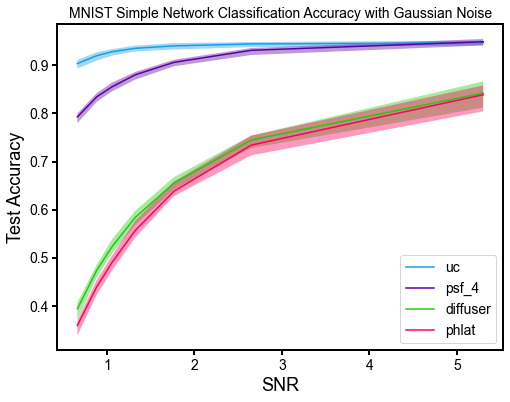

In [19]:
# simple network gaussian noise
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for modality in modality_list:
    error_lo, error_hi, mean = confidence_bars(gaussian_simple[modality_list.index(modality)], 7)
    ax.plot(gaussian_snr_axis, mean, '-', label=modality)
    ax.fill_between(gaussian_snr_axis, error_lo, error_hi, alpha=0.4)
plt.xlabel('SNR')
plt.ylabel('Test Accuracy')
plt.title('MNIST Simple Network Classification Accuracy with Gaussian Noise')
plt.legend()

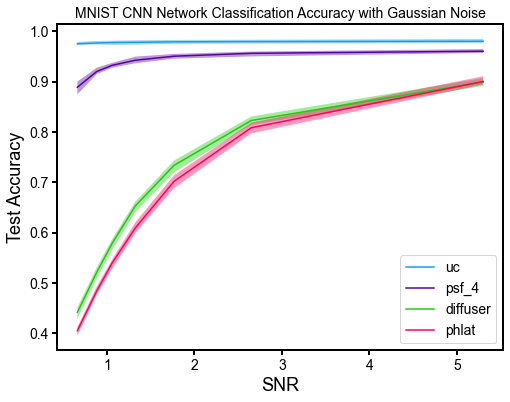

In [21]:
# cnn network gaussian noise
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for modality in modality_list:
    error_lo, error_hi, mean = confidence_bars(gaussian_cnn[modality_list.index(modality)], 7)
    ax.plot(gaussian_snr_axis, mean, '-', label=modality)
    ax.fill_between(gaussian_snr_axis, error_lo, error_hi, alpha=0.4)
plt.xlabel('SNR')
plt.ylabel('Test Accuracy')
plt.title('MNIST CNN Network Classification Accuracy with Gaussian Noise')
plt.legend()

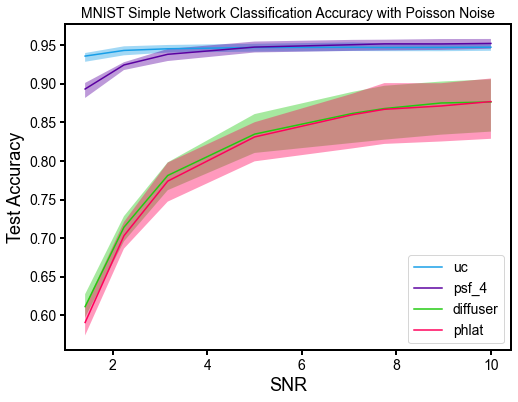

In [22]:
# simple network poisson noise
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for modality in modality_list:
    error_lo, error_hi, mean = confidence_bars(poisson_simple[modality_list.index(modality)], 8)
    ax.plot(poisson_snr_axis, mean, '-', label=modality)
    ax.fill_between(poisson_snr_axis, error_lo, error_hi, alpha=0.4)
plt.xlabel('SNR')
plt.ylabel('Test Accuracy')
plt.title('MNIST Simple Network Classification Accuracy with Poisson Noise')
plt.legend()

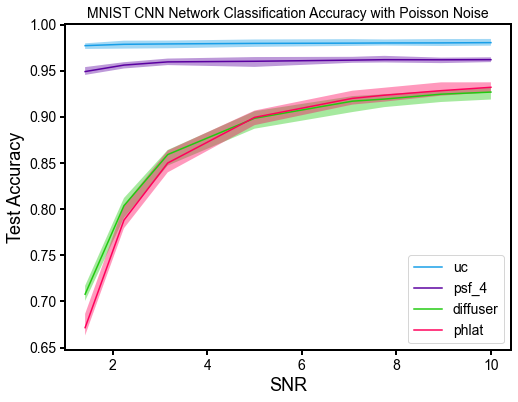

In [24]:
# cnn network poisson noise
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for modality in modality_list:
    error_lo, error_hi, mean = confidence_bars(poisson_cnn[modality_list.index(modality)], 8)
    ax.plot(poisson_snr_axis, mean, '-', label=modality)
    ax.fill_between(poisson_snr_axis, error_lo, error_hi, alpha=0.4)
plt.xlabel('SNR')
plt.ylabel('Test Accuracy')
plt.title('MNIST CNN Network Classification Accuracy with Poisson Noise')
plt.legend()

### Calculating Entropy

#### Example images of each dataset/imaging modality. No noise added.

In [26]:
num_patches_to_show = 4

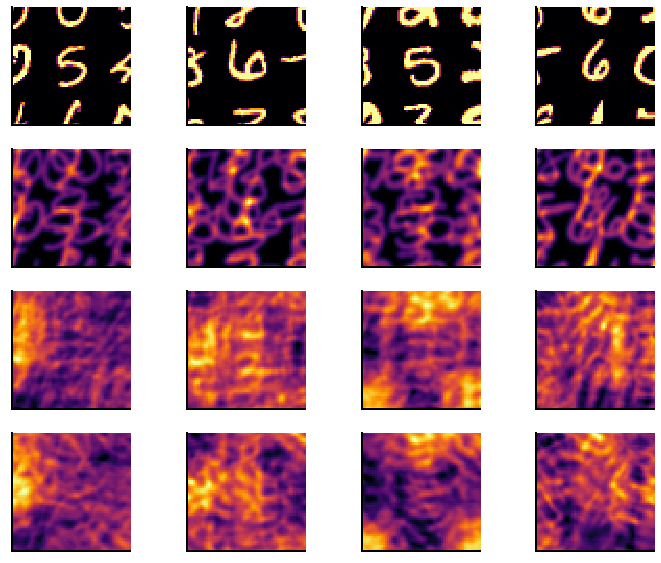

In [29]:
example_patch_fig, example_patch_axes = plt.subplots(len(modality_list), 
                                        num_patches_to_show, figsize=(3 * num_patches_to_show, len(modality_list) * 2.5))

for index, modality in enumerate([uc_data, psf_4_data, diffuser_data, phlat_data]):
    for j in range(num_patches_to_show):
        im = example_patch_axes[index, j].imshow(modality[j], cmap='inferno', interpolation='nearest')
        clear_spines(example_patch_axes[index, j])
        example_patch_axes[index, j].set(xticks=[], yticks=[])

#### Code to add noise to a dataset and calculate the entropy of the dataset. 

In [45]:
# use gaussian_noise_levels, poisson_noise_levels lists
# use add_gaussian_noise(data, noise_level, seed_value=*) and add_shot_noise(photon_images, photons_per_pixel=x, assume_noiseless=True, seed_value=*):
# calculate eigenvalues using compute_eigenvalues(data)
#format as entropy value uising compute_entropy(eigenvalues)
gaussian_entropy_estimates = [[], [], [], []]
for gaussian_noise in gaussian_noise_levels:
    print('computing noise level {}'.format(gaussian_noise))
    for dataset in [uc_data, psf_4_data, diffuser_data, phlat_data]:
        noisy_data = add_gaussian_noise(dataset, gaussian_noise, seed_value=1)
        eigenvalues = compute_eigenvalues(noisy_data)
        if eigenvalues.min() == 0:
            print('removing {} zero eigenvalues'.format(np.sum(eigenvalues == 0)))
        eigenvalues = eigenvalues[eigenvalues > 0]
        entropy = compute_entropy(eigenvalues)
        gaussian_entropy_estimates[gaussian_noise_levels.index(gaussian_noise)].append(entropy)


computing noise level 25
computing noise level 50
computing noise level 75
computing noise level 100
computing noise level 125


IndexError: list index out of range

In [ ]:
for modality in gaussian_entropy_estimates:
    plt.plot(gaussian_noise_levels, modality)

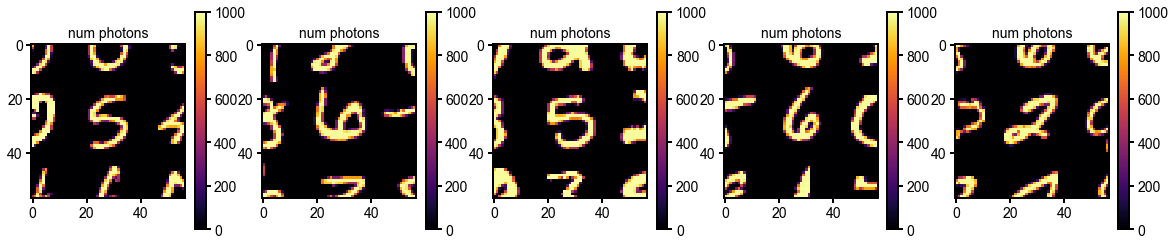

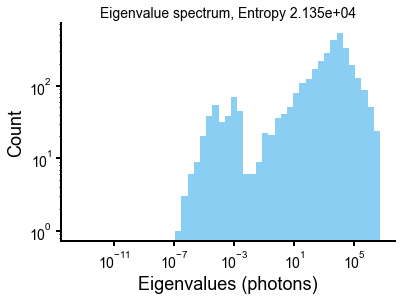

In [34]:
# calculate entropy for the raw unconvolved data. 

num_to_plot = 5
fig, axes = plt.subplots(1, num_to_plot, figsize=(20, 4))
for j in range(num_to_plot):
    axes[j].imshow(uc_data[j], cmap='inferno', interpolation='nearest')
    axes[j].set(title='num photons')
    fig.colorbar(axes[j].imshow(uc_data[j], cmap='inferno', interpolation='nearest'), ax=axes[j])


eigenvalues_uc_rt = compute_eigenvalues(uc_data)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_eigenval_hist(ax, eigenvalues_uc_rt, alpha=0.5)
ax.set(xlabel='Eigenvalues (photons)', ylabel='Count', title='Eigenvalue spectrum, Entropy {:.3e}'.format(compute_entropy(eigenvalues_uc_rt)))
clear_spines(ax)